Długość tekstu: 31599
Vocab size: 27
X shape: (31539, 60) y shape: (31539,)
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.1532 - loss: 2.9787 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5753 - loss: 1.5019 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9972 - loss: 0.2358 - learning_rate: 0.0010
Epoch 4/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0464
Stop: loss=0.0359 <= 0.1
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 1.0000 - loss: 0.0462 - learning_rate: 0.0010


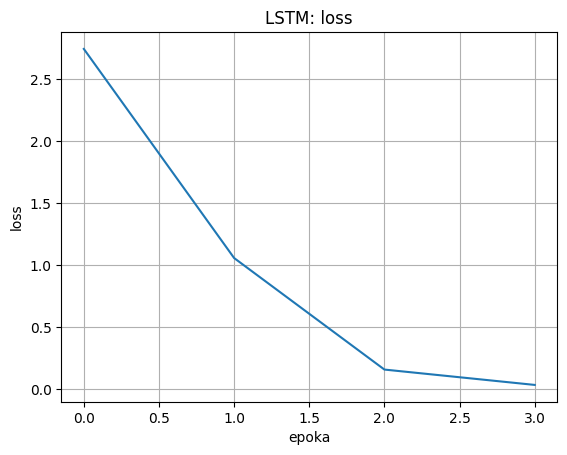

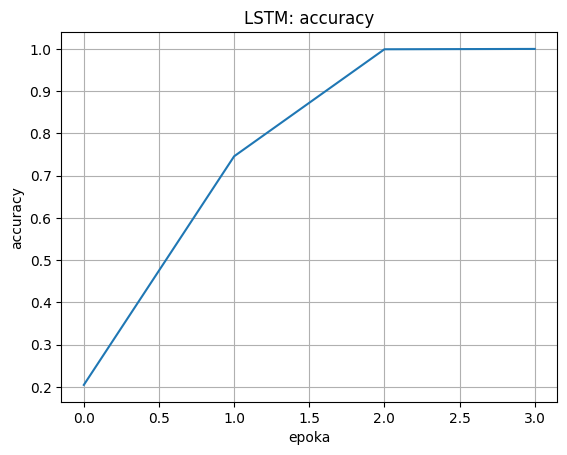


--- GENERATED ---
 Example tasks in which this is done include speech recognition commputer vision, translation between (nanuual) agngen, as, as well as otrks mppinis of xputee Eas terkh iw chh mpiiccio on, cllud sepech ranggnin ion ttmeus ees (natlatsingon theh in inpin on Eass tes sas tisn othin lpe ss sil rpinl tenas an, as 


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

text = ("Example tasks in which this is done include speech recognition, computer vision, "
        "translation between (natural) languages, as well as other mappings of inputs")

text = (text + " ") * 200
text = text.strip()

chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}

print("Długość tekstu:", len(text))
print("Vocab size:", vocab_size)

seq_len = 60
step = 1

X = []
y = []
for i in range(0, len(text) - seq_len, step):
    seq = text[i:i+seq_len]
    nxt = text[i+seq_len]
    X.append([char2idx[c] for c in seq])
    y.append(char2idx[nxt])

X = np.array(X, dtype=np.int32)
y = np.array(y, dtype=np.int32)

print("X shape:", X.shape, "y shape:", y.shape)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_len,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

class StopAtLoss(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super().__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss", None)
        if loss is not None and loss <= self.threshold:
            print(f"\nStop: loss={loss:.4f} <= {self.threshold}")
            self.model.stop_training = True

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    StopAtLoss(0.1)
]

hist = model.fit(
    X, y,
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

# --- Wykresy ---
plt.figure()
plt.plot(hist.history["loss"])
plt.title("LSTM: loss")
plt.xlabel("epoka")
plt.ylabel("loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"])
plt.title("LSTM: accuracy")
plt.xlabel("epoka")
plt.ylabel("accuracy")
plt.grid(True)
plt.show()

def sample_from_probs(probs, temperature=0.8):
    probs = np.asarray(probs).astype(np.float64)
    probs = np.log(probs + 1e-12) / temperature
    probs = np.exp(probs) / np.sum(np.exp(probs))
    return np.random.choice(len(probs), p=probs)

def generate(seed_text, n_chars=200, temperature=0.8):
    out = seed_text
    for _ in range(n_chars):
        seq = out[-seq_len:]
        seq_idx = np.array([[char2idx[c] for c in seq]], dtype=np.int32)
        probs = model.predict(seq_idx, verbose=0)[0]
        nxt_idx = sample_from_probs(probs, temperature=temperature)
        out += idx2char[nxt_idx]
    return out

seed = text[:seq_len]
gen = generate(seed, n_chars=250, temperature=0.7)
print("\n--- GENERATED ---\n", gen)
